**Arabic text  to English GPT2 Translator**

In [1]:
!pip install datasets transformers sacrebleu
!pip install sentencepiece
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.

In [2]:
import re
import json
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from nltk.translate.bleu_score import corpus_bleu
from collections import Counter
import sacrebleu

In [18]:
# Load and preprocess dataset
with open('/content/Arabic.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract and align English and Arabic sentences
en_sentences = [entry['input'] for entry in data[:1000]]
ar_sentences = [entry['output'] for entry in data[:1000]]

# Print the first 5 English and Arabic sentences
print("First 5 English sentences:")
for sentence in en_sentences[:5]:
    print(sentence)

print("\nFirst 5 Arabic sentences:")
for sentence in ar_sentences[:5]:
    print(sentence)

# Initialize tokenizer with custom separator
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'additional_special_tokens': ["<|sep|>"]})
tokenizer.pad_token = tokenizer.eos_token

# Tokenizer helper for vocabulary creation
tokenizer_func = lambda x: x.split()

def build_vocab(sentences):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer_func(sentence))
    return counter

en_vocab = build_vocab(en_sentences)
ar_vocab = build_vocab(ar_sentences)

# Adding special tokens to vocabulary
en_vocab = {'<s>': 1, '</s>': 2, '<pad>': 0, '<unk>': 3, **en_vocab}
ar_vocab = {'<s>': 1, '</s>': 2, '<pad>': 0, '<unk>': 3, **ar_vocab}

def sentence_to_tensor(sentence, vocab, max_len=128):
    tokens = tokenizer_func(sentence)
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
    indices = [vocab['<s>']] + indices + [vocab['</s>']]
    if len(indices) < max_len:
        indices += [vocab['<pad>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return torch.tensor(indices)

First 5 English sentences:
Give three tips for staying healthy.
1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.
What are the three primary colors?
The three primary colors are red, blue, and yellow. These colors are called primary because they cannot be created by mixing other colors and all 

In [4]:
# Data preparation
def encode_translation_pairs(inputs, outputs, tokenizer, max_len=128):
    translations = [
        f"{inputs[i]} <|sep|> {outputs[i]}"
        for i in range(len(inputs))
    ]
    return tokenizer(
        translations,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )["input_ids"]

encoded_data = encode_translation_pairs(en_sentences, ar_sentences, tokenizer)

# Create a Dataset object
dataset = Dataset.from_dict({"input_ids": encoded_data, "labels": encoded_data})

# Split datasets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
train_dataset, temp_dataset = dataset.train_test_split(train_size=train_size).values()
val_dataset, test_dataset = temp_dataset.train_test_split(train_size=val_size).values()

In [5]:
# Load and configure the model
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Print the model configuration
print(model.config)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.46.3",
  "use_cache": true,
  "vocab_size": 50258
}



In [6]:
# Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # No masking
)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to=[]
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model
print("Training started!")
trainer.train()
print("Training complete!")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-a52d4ab58833>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started!


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Training complete!


In [14]:

import re
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Test sentences for translation (these are just examples)
test_samples = [
    "The cat is sitting on the window.",
    "I need to buy a new phone.",
    "She loves reading books during her free time.",
    "The train arrives at 7 PM.",
    "I enjoy listening to music while working.",
    "The meeting has been scheduled for tomorrow.",
    "Can you recommend a good restaurant nearby?",
    "I have finished my homework for the day.",
    "The city is known for its beautiful parks.",
    "Do you prefer tea or coffee?"
]


# Add a special token for separator
tokenizer.add_special_tokens({'additional_special_tokens': ["<|sep|>"]})
model.resize_token_embeddings(len(tokenizer))

# Function to translate sentences
def translate_sentence(model, tokenizer, sentence):
    input_text = f"{sentence} <|sep|>"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    attention_mask = tokenizer(input_text, return_tensors="pt").attention_mask.to(model.device)

    # Generate translation
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        top_k=50,
        repetition_penalty=3.0,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id
    )

    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Clean up translated text (remove anything before punctuation marks)
    match = re.search(r'[.?!]', translated_text)
    if match:
        translated_text = translated_text[match.end():].strip()

    return translated_text

# Translate test sentences
print("\nTest Sentence Translations:")
for sentence in test_samples:
    translation = translate_sentence(model, tokenizer, sentence)
    print(f"English: {sentence}")
    print(f"Arabic: {translation}\n")



Test Sentence Translations:
English: The cat is sitting on the window.
Arabic: أجد في المقالة وتواسلها من: "سبع" = 10/4ر
1) 9-5 cm x 6cm (2). 2)(

English: I need to buy a new phone.
Arabic: أعد كتابة مثليق المسبوان والره�, "Budu". #102625 https://tribalnews3rv4p

English: She loves reading books during her free time.
Arabic: هذه البانتي إلى مساعة ومعدور (ال1) https://www2h4xl8y7n5/diyar-al

English: The train arrives at 7 PM.
Arabic: بإنتاسيار موعلة 5 فهمد 3 البالً 4 وسَ� 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24

English: I enjoy listening to music while working.
Arabic: أحمد في النترقائة والعباول مسه, #al-Baqara https://tribulationworld.wordpress/
‹�Euph

English: The meeting has been scheduled for tomorrow.
Arabic: أعد كتابة الجملين والورباهً مسی "Jihad". #jihadi
’- The following is a list of the items that

English: Can you recommend a good restaurant nearby?
Arabic: أعد قائمة الصنيف والسبار. مهوتل: "A great meal at the best price". #jihadpics
‌🊥

English: I have finished 

In [15]:
# Perplexity Calculation
# Perplexity Calculation
def calculate_perplexity(model, tokenizer, sentences):
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# CHRF Score Calculation
def calculate_chrf_score(references, translations):
    # sacrebleu's chrf_score expects the references and translations as a list of strings.
    chrf = sacrebleu.corpus_chrf(references, translations)
    return chrf.score

# BLEU Score Calculation
def calculate_bleu_score(references, translations):
    references = [[ref.split()] for ref in references]
    translations = [trans.split() for trans in translations]
    return corpus_bleu(references, translations)

# Evaluate translations
translated_sentences = [translate_sentence(model, tokenizer, s) for s in en_sentences[:5]]
perplexity = calculate_perplexity(model, tokenizer, en_sentences[:5])
bleu_score = calculate_bleu_score(ar_sentences[:5], translated_sentences)
chrf = calculate_chrf_score(ar_sentences[:5], translated_sentences)

print(f"\nPerplexity: {perplexity}")
print(f"BLEU Score: {bleu_score}")
print(f"CHRF Score: {chrf}")





Perplexity: 2849.4482421875
BLEU Score: 0
CHRF Score: 16.0


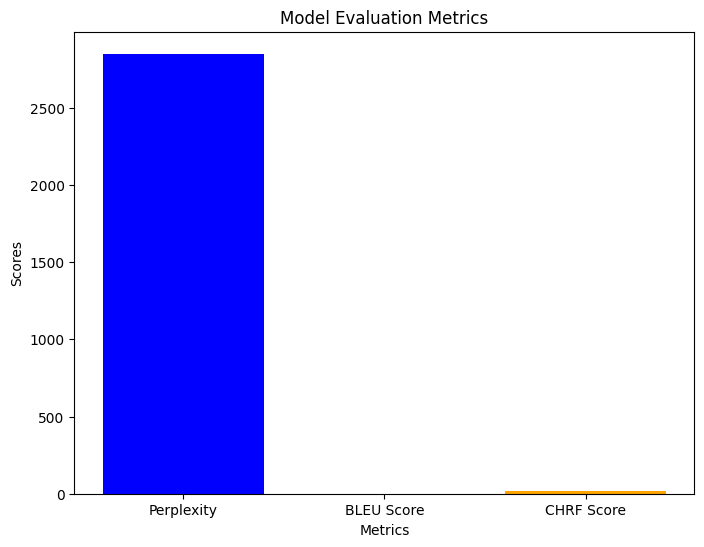

In [19]:
# Plotting Results
def plot_results(perplexity, bleu_score, chrf):
    # Metrics for plotting
    metrics = ['Perplexity', 'BLEU Score', 'CHRF Score']
    values = [perplexity, bleu_score, chrf]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['blue', 'green', 'orange'])
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Model Evaluation Metrics')
    plt.show()

# Plot the results
plot_results(perplexity, bleu_score, chrf)